# NOTE THIS NOTEBOOK HAS NOW BEEN RE-RUN ON MODEL TRAINED ON MAE LOSS INSTEAD OF MSE LOSS

### Relevant Imports

In [1]:
import os
import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

In [2]:
# equivalent to spatial

import hydra
from hydra.experimental import compose, initialize

with initialize(config_path="../config"):
    cfg_from_terminal = compose(config_name="config")
    output = test(cfg_from_terminal)

/home/roko/.cache/pypoetry/virtualenvs/spatial-1lQwL2nz-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/roko/spatial-main//output/lightning_logs/checkpoints/MonetAutoencoder2D exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/roko/.cache/pypoetry/virtualenvs/spatial-1lQwL2nz-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.9060461521148682}
--------------------------------------------------------------------------------


# MAE Imaging

In [3]:
import matplotlib.pyplot as plt

trainer, l1_losses, inputs, gene_expressions = output

In [4]:
print(l1_losses.shape)
print(l1_losses.mean())
print(l1_losses)

torch.Size([173509, 160])
tensor(0.9072)
tensor([[1.7426e-03, 9.5490e-04, 7.6199e-01,  ..., 2.3717e-04, 7.2252e-04,
         1.1640e+00],
        [2.0232e-03, 1.6102e-04, 1.1052e+00,  ..., 1.2074e-02, 2.5227e-03,
         7.4367e-05],
        [2.1792e-03, 1.4550e-03, 2.6436e-01,  ..., 1.1994e-03, 8.0184e-03,
         1.3908e-03],
        ...,
        [2.5906e-03, 1.0919e-03, 5.0679e-02,  ..., 2.1174e-02, 5.4465e-03,
         1.2162e-04],
        [2.5370e-03, 1.2609e-03, 1.1951e-01,  ..., 1.8989e-02, 7.2698e-03,
         1.3143e-04],
        [1.4355e+00, 9.4894e-04, 1.0463e-02,  ..., 6.5755e-03, 4.3535e-03,
         1.0200e-04]])


#### For a single sample.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f74abf8aca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f74abf25fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f74abf8aee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f74abf7eb80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f74abf71b20>],
 'means': []}

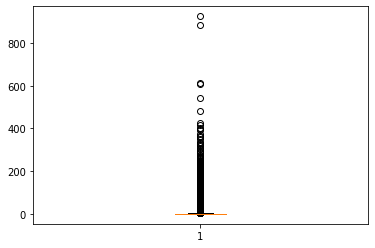

In [5]:
plt.boxplot(l1_losses.reshape(1,-1))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f763a8de670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f763a8ded30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f763a8de310>],
 'medians': [<matplotlib.lines.Line2D at 0x7f763a8ea430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f763a8ea790>],
 'means': []}

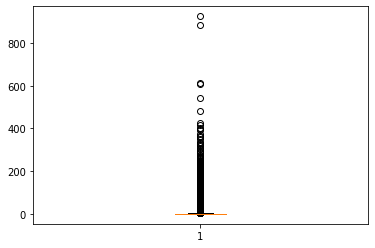

In [6]:
plt.boxplot(l1_losses.reshape(1,-1)[:,:])

In [7]:
import pandas as pd

# get relevant data stuff
df_file = pd.ExcelFile("~/spatial-main/data/messi.xlsx")
messi_df = pd.read_excel(df_file, "All.Pairs")
merfish_df = pd.read_csv("~/spatial-main/data/merfish.csv")


# these are the 13 ligands or receptors found in MESSI
non_response_genes = ['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 
                      'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt',
                      'Tac2']
# this list stores the control genes aka "Blank_{int}"
blank_genes = []
# ligands and receptor indexes in MERFISH
non_response_indeces = [list(merfish_df.columns).index(gene)-10 for gene in non_response_genes]
all_pairs_columns = [
    "Ligand.ApprovedSymbol",
    "Receptor.ApprovedSymbol",
]

# for column name in the column names above
for column in all_pairs_columns:
    for gene in merfish_df.columns:
        if (
            gene.upper() in list(messi_df[column])
            and gene.upper() not in non_response_genes
        ):
            non_response_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-10)
        if gene[:5] == "Blank" and gene not in blank_genes:
            blank_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-10)
print(non_response_genes)
print(
    "There are "
    + str(len(non_response_genes))
    + " genes recognized as either ligands or receptors (including new ones)."
)

/home/roko/.cache/pypoetry/virtualenvs/spatial-1lQwL2nz-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr']
There are 71 genes recognized as either ligands or receptors (including new ones).


In [8]:
inputs.mean(axis=0)

tensor([3.2387e-01, 2.9961e-01, 3.0229e+00, 1.5792e+00, 4.4137e-01, 4.9569e+00,
        3.4527e+00, 2.2754e+00, 3.6645e-01, 2.8887e-01, 9.9600e-01, 8.6463e-01,
        2.2534e-01, 1.7905e-01, 1.9609e-01, 1.3896e-01, 5.0392e-01, 6.5318e-01,
        4.4651e-01, 6.2347e-01, 8.6101e-01, 9.6052e+00, 1.6350e+00, 5.4654e-01,
        9.4241e-01, 2.1755e+00, 1.2680e+00, 5.9079e-01, 6.9673e-01, 4.7572e-01,
        1.2076e+00, 3.7874e-01, 7.8100e-01, 1.3590e+00, 2.7162e-01, 4.3763e-01,
        4.0710e-01, 5.3421e+00, 4.3155e+00, 4.2989e-01, 1.4223e-01, 9.0313e-01,
        2.9800e+00, 9.1395e-01, 3.4507e-01, 8.1374e+00, 6.4894e-01, 7.9419e-01,
        1.9998e-01, 4.5092e-01, 1.9462e+00, 9.3675e-01, 5.0619e+00, 1.2119e+00,
        1.1131e+01, 5.1745e-01, 6.4372e-01, 2.1097e-01, 2.9809e+00, 3.3619e-01,
        3.2514e+00, 2.7524e+00, 4.6187e+00, 5.2362e-01, 5.6481e-01, 2.2756e+00,
        3.3924e+00, 7.3716e-01, 6.9037e+00, 4.6608e-01, 5.7801e-01, 8.5759e-01,
        3.0088e-01, 2.8208e-01, 3.6981e-

Initial Response Expression Mean: 1.9034157991409302
Initial Non-Response Expression Mean: 1.1825134754180908
AE Response Expression Mean: 1.2257163524627686
AE Non-Response Expression Mean: 0.6699910163879395
Average L1 Loss: 0.907152533531189
Average L1 Loss for Mean 0.6307252645492554
                0
count  160.000000
mean     0.630725
std      0.616160
min      0.008643
25%      0.258202
50%      0.455086
75%      0.812926
max      4.434734


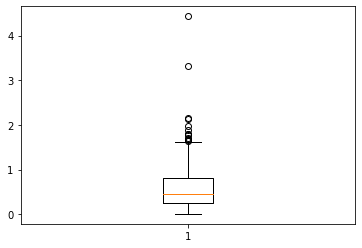

Average L1 Loss for Mean among Response Genes: 0.7376704216003418
Average L1 Loss for Mean among Non-Response Genes: 0.5125225186347961


In [9]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

non_response_inputs = torch.index_select(inputs, 1, torch.tensor(non_response_indeces))
response_inputs = torch.index_select(inputs, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("Initial Response Expression Mean: " + str(response_inputs.mean().item()))
print("Initial Non-Response Expression Mean: " + str(non_response_inputs.mean().item()))

non_response_expressions =  torch.index_select(gene_expressions, 1, torch.tensor(non_response_indeces))
response_expressions = torch.index_select(gene_expressions, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("AE Response Expression Mean: " + str(response_expressions.mean().item()))
print("AE Non-Response Expression Mean: " + str(non_response_expressions.mean().item()))

print("Average L1 Loss: " + str(l1_losses.mean().item()))

mean_MAE_L1 = F.l1_loss(inputs.mean(axis=0), gene_expressions.mean(axis=0)).item()

print("Average L1 Loss for Mean " + str(mean_MAE_L1))

response_gene_boxplot = abs(inputs.mean(axis=0) - gene_expressions.mean(axis=0))
print(pd.DataFrame(response_gene_boxplot).describe())
plt.boxplot(response_gene_boxplot.reshape(1,-1))
_ = plt.show()

mean_MAE_response_L1 = F.l1_loss(response_inputs.mean(axis=0), response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Response Genes: " + str(mean_MAE_response_L1.item()))

mean_MAE_non_response_L1 = F.l1_loss(non_response_inputs.mean(axis=0), non_response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Non-Response Genes: " + str(mean_MAE_non_response_L1.item()))

In [10]:
response_inputs.mean(axis=0)

tensor([ 0.3239,  3.0229,  1.5792,  0.4414,  4.9569,  3.4527,  2.2754,  0.9960,
         0.9424,  2.1755,  1.2680,  0.5908,  0.6967,  0.4757,  1.2076,  0.3787,
         0.7810,  1.3590,  5.3421,  0.4299,  0.1422,  2.9800,  0.9139,  0.3451,
         8.1374,  0.6489,  0.7942,  0.2000,  0.4509,  0.2110,  2.9809,  0.3362,
         3.2514,  0.5236,  6.9037,  0.4661,  0.8576,  0.3009,  0.3698,  1.8747,
         0.3040,  3.6621,  1.2378,  0.6364, 11.6746,  2.7314,  2.2307,  0.4656,
         0.2479,  1.0650,  1.4291,  1.1185, 15.6989,  1.8167,  0.7810,  1.1501,
         1.5404,  1.5878,  4.8581,  1.6911,  0.5131,  0.4380,  8.4062,  0.2967,
         4.8329,  0.2032,  3.5875,  2.6885,  1.3616,  1.8380,  0.3436,  1.0942,
         1.1327,  3.3220,  1.1227,  1.5411,  1.4264,  0.7440,  0.2428,  2.7146,
         0.3961,  0.0625,  0.1844,  0.0825])

In [11]:
response_expressions.mean(axis=0)

tensor([ 6.3138e-02,  2.3921e+00,  7.9798e-01, -6.8328e-05,  3.9088e+00,
         1.8355e+00,  6.2800e-01,  7.4539e-01,  2.3026e-01,  3.7165e-01,
         1.7657e-01,  2.6947e-04,  2.3797e-01, -2.7430e-05,  6.6038e-01,
         2.0578e-05,  5.5260e-01,  4.0107e-01,  5.2468e+00, -6.5897e-05,
         1.2217e-04,  2.6442e+00, -1.8052e-04, -2.0059e-05,  3.7026e+00,
         3.0086e-01,  5.7074e-02, -1.2390e-04, -2.5082e-06, -1.4063e-04,
         1.9038e+00,  2.8513e-04,  2.8450e+00,  3.3529e-04,  5.7639e+00,
         5.2585e-03,  2.7591e-01, -5.1766e-05,  1.0129e-01,  3.3190e-01,
        -2.0126e-04,  4.3960e+00,  9.5754e-01, -9.8759e-05,  1.2017e+01,
         5.9060e-01,  1.2017e+00,  7.7867e-06, -1.9967e-06,  3.8617e-01,
         3.2867e-01,  6.6704e-01,  1.2382e+01,  8.5001e-01,  4.6430e-01,
         4.3313e-01,  4.4768e-01,  5.5042e-01,  4.4248e+00,  5.5431e-01,
         4.2988e-04,  1.3513e-03,  6.2512e+00,  9.8100e-05,  3.0641e+00,
         1.1476e-05,  3.1425e+00,  1.2557e+00,  1.0

It looks like that our autoencoder is underguessing on HIGHLY expressed genes. Which to be fair is a rare occurrence.

Looking at response gene 52, we can see that it is consistently very highly expressed... 

In [12]:
pd.DataFrame(response_inputs[:,52]).describe()

,0
count,173509.000000
mean,15.698905
std,17.255470
min,0.000000
25%,1.480469
50%,10.085938
75%,25.406250
max,426.750000


but the AE predicts fairly low. This is ofc without masking.

In [13]:
pd.DataFrame(response_expressions[:,52]).describe()

,0
count,173509.000000
mean,12.382073
std,11.692189
min,-35.725933
25%,2.810833
50%,7.861497
75%,19.754047
max,479.852600


The negative predictions are a bit annoying, but really do not influence mean prediction too much and still largely underpredicts the mean expression value.

In [14]:
proj_response_expressions = response_expressions
proj_response_expressions[proj_response_expressions < 0] = 0
pd.DataFrame(proj_response_expressions[:,52]).describe()

,0
count,173509.000000
mean,12.383664
std,11.689078
min,0.000000
25%,2.810833
50%,7.861497
75%,19.754047
max,479.852600


In [15]:
52 in non_response_indeces

True

In [16]:
merfish_df['Cell_class'].unique()

array(['Astrocyte', 'Inhibitory', 'OD Mature 2', 'Endothelial 1',
       'Ambiguous', 'Pericytes', 'Endothelial 2', 'OD Mature 1',
       'OD Immature 1', 'Excitatory', 'Microglia', 'Endothelial 3',
       'OD Mature 4', 'OD Immature 2', 'OD Mature 3', 'Ependymal'],
      dtype=object)

The 8 cell types that were used to create the MAE graph in MESSI were...

In [17]:
MAE_cell_types =['Astrocyte', 'Inhibitory', 'OD Mature 2', 'Endothelial 1',
       'OD Mature 1', 'OD Immature 1', 'Excitatory', 'Microglia', ]

In [18]:
merfish_df.shape

(1027848, 170)

In [21]:
inputs[0].shape

torch.Size([160])

# Checklist of Things To Do:

- [x] Compare runs on tensorboard.
- [ ] Ensure that outputs for every test example get saved (i.e. we should have a list of 31 tensors.)
- [ ] Filter out outputs based on their respective celltype values (y).
- [ ] Implement XGBoost on the 8 celltypes with pip install xgboost.
- [ ] Make batch size hydra parameter.
- [ ] Try multi-batch run with appropriate batch size and n_neighbors.
- [ ] Change logger to only log MAE.
- [ ] Add nbstripout to poetry.
- [ ] Figure out how to label tensorboard folders.